In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline

## data analysis trio :)
import matplotlib.pyplot as plt # plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns; sns.set_style('whitegrid')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Load data set

In [ ]:
df = pd.read_csv('../input/winequality-red.csv')

print(df.shape)

df.head()

# Explore

Check some basic distribution and correlation


# Prepare dataset for machine learning

Turn the wine quality into a binary classification probblem, into good quality and not good quality wines.
 
To do this we would like to check what the distribution of the quality looks like:

In [ ]:
_tmp = df.quality.value_counts().sort_values()
plt.barh(_tmp.index, _tmp)

plt.show()

_tmp = df.quality.value_counts(normalize=True).sort_values()
print(_tmp)

From the above plot it makes sense that if we decide to consider the quality above 6 as 'good' (which roughly 14% of total)

In [ ]:
ml_df = df.copy() # In general it would be good to not touch the originial raw data frame :)
ml_df['is_good'] = df.quality.apply(lambda q: True if q>=7 else False)

_tmp = ml_df.is_good.value_counts().sort_values()
print("-"*10, "total good/bad", "-"*10)
print(_tmp)

In [ ]:
sns.pairplot(ml_df, hue='is_good')


## Train/test split
The next step is to conver the above into numpy arrays for the easiness for machine learning. We also prepare the training/test set. **though train/test is a very simple step for toy problem, but in real-life application, there's a catch: we need to keep the identifier of each data point to allow the results mappable back to the source,** this is usually required in a complex data analysis project involving multiple data sources. we will not address this here as this data set is very self-contained.

Just a note: I deliberately didn't use any facilitating functiosn from `sklearn` such as `train_test_split` is because of the above potential issue, I want to keep the flexibility at max.


In [ ]:
ml_df.columns

ftr_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [ ]:

train_ratio = .8

train_num = int(train_ratio * len(df))
shuffled = ml_df.sample(len(df))

X, y = np.array(shuffled[ftr_names]), np.array(shuffled.is_good)

X_train, X_test = X[:train_num], X[train_num:]
y_train, y_test = y[:train_num], y[train_num:]

print(f"total number of training points: {len(X_train)} with {sum(y_train)} positive example")
print(f"total number of test points: {len(X_test)} with {sum(y_test)} positive example")

Some observations:
- we don't have much positive examples in our test data set
- and this has skewed distribution (circa 14% positive)


# Benchmarking

Whenever encounter an machine learning problem, the first thing to think is: how difficult the problem is? Of course there are some interesting & cool complex analysis can be done with it. 
 
However, under time constraints, normally the easiest thing to do is to apply the simplest/most robust out-of-box algorithm. I find [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine) is a good candidate for benchmarking. The reasons are:
- **Robust**: Linear SVM tends to underfit rather than overfit, and thus very robust against complex/noisy dataset, and for the purpose of benchmarking, this is a desired behaviour.
- **Explaniability**: it's linear when linear kernel is applied, thus can provide a good feature explanation regardless with how good/bad the results are.
- **Well studied**: SVM is heavily studied in academics, so whatever behaviour it shows, you can probably find a good explanation in literatures.
- **Can be complex**: Things get very interesting when non-linear kernel kicks in, with minor tweak from default you can reach a reasonable good performance for many classification problems.


## From most basic SVC
Here we put the most basic out-of-box learner to benchmark how hard/easy this problem is.


In [ ]:
from sklearn.svm import SVC

lsvc= SVC(kernel='linear')
lsvc.fit(X_train, y_train)

s_train = lsvc.decision_function(X_train)
s_test = lsvc.decision_function(X_test)

This is the lazest thing we can do to create a model ;p

The most important things to note is not what we did, but what we didn't do:
- we didn't tune any parameters, everything is default (though we should at least tune the `max_itr` as it is throughing convergence warning)
- we didn't use any normalisation/standardisation to add to the pipeline
- we didn't do any re-sampling to balance the effects of the skewed distribution

However, we did:
- instead of calculate the estimate $\hat{y}$, we calculated the decision function's values, which serve as the score of the output.
- it is very important for us to get the measures we want
 

## Evaluate the results

I consider evaluation of the results is more important than building the model itself, right measures direct you to the right directions and wrong ones will direct you to the wrong ones.

- **Accuraccy**: In this particular case, Accuracy is definitely the *WRONG* measure. Consider if we create a classifier always say False, then we are about 86% correct, since we only have 14% positives
- **ROC curve & AUC**: ROC can be helpful but can be misleading:
    - it helps to understand the trade-off between the recall and false positive
    - but in the skewed case, we can have a not-too-bad AUC, but interpretation needs to be very careful: consider we have TPR 90% with 10% FPR. Assume we have 10 positive case v.s. 90 negative case. Then for all the case model says positive, we have 9 true positives with 90% TPR, and 9 false positives from 10% FPR. This gives us only 50% precision.
    - is this bad? Depends on use cases: imagine this is about good/bad wines, if you depend on model to retrieve good wines, then half of the wines it recommends you are not good, so probably not supper good. But change the perspective, if you depends on the model to filter out all the bad wines, then it is probably not too bad: you rejected 90% of bad wines but only missed 1 good wine :)
- **Precision-Recall**: it is in general the best choice in this particular case.


In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

def show_pr_curve(y_train, s_train, y_test, s_test):
    ap_train = average_precision_score(y_train, s_train)
    ap_test = average_precision_score(y_test, s_test)

    prc_train, rec_train, _ = precision_recall_curve(y_train, s_train)
    prc_test, rec_test, _ = precision_recall_curve(y_test, s_test)

    plt.figure(figsize=(8, 8))
    plt.plot(rec_train, prc_train)
    plt.plot(rec_test, prc_test)
    plt.ylabel("precision")
    plt.xlabel("recall")
    plt.legend([f'train (ap: {ap_train})', f'test (ap: {ap_test})'])
    plt.show()
show_pr_curve(y_train, s_train, y_test, s_test)


Two observations:
- The performance of the model is not super, but ok
- It seems there's no overfitting, as the training and testing performances are similar



# Addressing imbalanceness

As mentioned before, the class distribution is not balanced, we wish to identify 14% positive classes. There are two ways we can try to address this issue:

- **Resample**: rebalancing the training data set (not test of course). This is a generic method to deal with imbalance data, but not necessarily render good results
- **Adjust class weight accordingly**: For SVM we can adjust class weight to address the issue as well.



## Why is this a problem?

We all understand that imbalanceness is bad, but why exactly? At a high level, to classifier, the minority class is very much underrepresented, and in general the minority class is the one that we are interested.

For SVM, we the direct consequence is that our decision boundary (hyperplane) will be pushed more to positive class and categorize more negative classes, just as shown in the following figure.

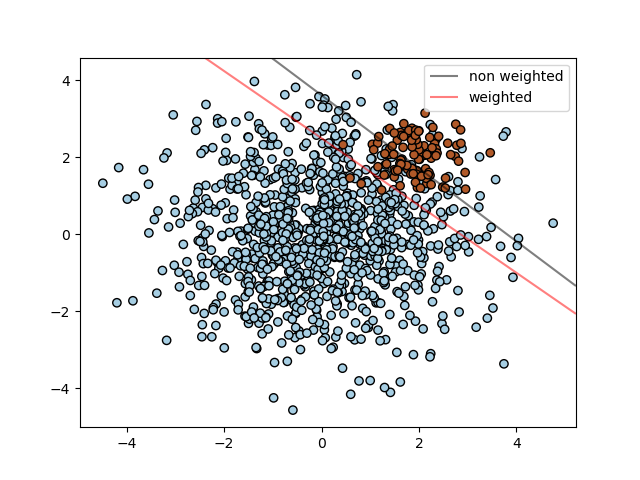 <a name="figure1"><p style="text-align: center;">**Figure 1**: illustrate the effect of imbalanceness (source: [sklearn](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html))</p>


For the ones who are very interested in the detailed math, let's consider in general the cost function for SVM:
\begin{align}
    \min_{w, b, \epsilon} &\frac{1}{2}\|w\|_2^2 + C\sum_i^N \epsilon_i \\
    \text{s.t. } &1 - y_i(w^\top x_i + b) \leq \epsilon_i \text{ for $i = 1, \cdots N$} \\
                &\epsilon \geq 0
\end{align}

where $y_i\in \{-1, 1\}$ represents the negative and positive class respectively. The above is fairly standard and you can see it from every where, but to understand what is going on we need to slightly deeper...

Now we change the above formulation's notation a bit (but exactly the same problem), we change the weight for slack variable $C$ to vector form $c := [c_1, c_2, \cdots c_N]\in \mathbb{R}^N$ and for now, $c_1=c_2\cdots=c_N=C$.

we create 2 index sets:
- $\mathbb{I}_+ := \{i\ |\ y_i=1\}$ the set of $i$ for all $y_i=1$.
- $\mathbb{I}_- := \{i\ |\ y_i=-1\}$ the set of $i$ for all $y_i=-1$.

So the above problem can be written as 

\begin{align}
    \min_{w, b, \epsilon} &\frac{1}{2}\|w\|_2^2 + [c_+^\top,\ c_-^\top]\epsilon\\
    \text{s.t. } &1 - (w^\top x_i + b) \leq \epsilon_i \text{  for $i \in \mathbb{I}_+$} \\
                 &w^\top x_i + b - 1 \leq \epsilon_i \text{  for $i \in \mathbb{I}_-$} \\
                &\epsilon \geq 0
\end{align}

If positive is far less numerous than negative class, and $c_i$ are all the same for $i\in \mathbb{I}_+$ and $i\in \mathbb{I}_-$. Then one can imagine the benefit of not violating constraints with index in $\mathbb{I_+}$ is far less than the benefit of not violating constrants with index in $\mathbb{I_-}$. Because we have more corresponding $\epsilon_i$ in negative than in positive.

The above formulation also offers a solution to this problem: we just need to set accordingly the class weights $c_+$ and $c_-$ accordingly to compensate the ratio. And fortunately `sklearn` allows us to do this easily :)



## Apply class weight


In [ ]:
from sklearn.svm import SVC # note we are not using LinearSVC any more, as we may change the kernel later

pos_ratio = ml_df.is_good.sum()/ml_df.is_good.count()

print("positive ratio is:", pos_ratio)

class_weight = {True: 1/pos_ratio, False: 1}
svc = SVC(kernel='linear', class_weight=class_weight)

svc.fit(X_train, y_train)

s_train = svc.decision_function(X_train)
s_test = svc.decision_function(X_test)

show_pr_curve(y_train, s_train, y_test, s_test)



Sadly, it looks like it doesn't make much difference, which is common. So the next step is to try the resample.


## Resample

There are various ways for re-balancing data sets:
- **down sample**: discard extra majoirty class to achieve a balanced data set, it is simple but we can only use it when we have sufficient data
- **over sample**: alternatively we can over sample the minority class, either by repeatitively sample each positive data point, or use more advanced technques such as [SMOTE](https://arxiv.org/pdf/1106.1813.pdf).

Here let's focus on simple stuff, let's just down sample


In [ ]:
from random import sample

neg_ind = list(np.where(y_train==False)[0])
pos_ind = list(np.where(y_train==True)[0])

print(f"there are in total {len(neg_ind)} negatives")
print(f"there are in total {len(pos_ind)} positive")

neg_size = len(pos_ind)

downsampled_ind = sample(neg_ind, neg_size) + pos_ind # create a balanced indices
downsampled_ind = sample(downsampled_ind, len(downsampled_ind)) # and reshuffle it a bit

X_train_dwnsmp, y_train_dwnsmp = X_train[downsampled_ind, :], y_train[downsampled_ind]

print(f"there are in total {len(y_train_dwnsmp[y_train_dwnsmp==False])} negatives after down sample")
print(f"there are in total {len(y_train_dwnsmp[y_train_dwnsmp==True])} positive after down sample")


Looks like after downs sample, we have much less data to work with now. But let's see how it goes.

**NOTE** since we have rebalanced the data, there's no need to have calss weight any more

In [ ]:

svc = SVC(kernel='linear')

svc.fit(X_train_dwnsmp, y_train_dwnsmp)

s_train = svc.decision_function(X_train_dwnsmp)
s_test = svc.decision_function(X_test)

show_pr_curve(y_train_dwnsmp, s_train, y_test, s_test)


Immediately we see a great boost in performance in training set. The observation here is:
- AP boosted significantly within training set
- But not really any boost within testing set, this is because in test set, we didn't do any rebalancing (and we shouldn't).

Moral of the story: balanced data set is much easier to deal with!

## So why not work?

This is actually precisely because of the metric we choose: **average precision is a metric on the scores rather than discrete output** and this is less affected than other metrics which applies to discrete output by the imbalanceness in some cases.

A case in point would be what shows in <a ref="figure1">Figure 1</a> eariler, we can see if SVC uses linear kernel, tuning the weight changed significantly where the boundary is, but only very slightly on the orientation of the hyperplane. This observation leads to:
- the AP will not be affected strongly: because the only thing affected significantly was the cardinal value of the scores(distances), but not the ordinal order, meaning that if you raise threshold that separates positive to negative gradually, you will get similar TP/FP/TN/FN and consequently similar AP.
- similar conclusion can be said to down sample as well.

The following code shows that in contrast to metrics relies on thresholds (AP, AUC), the metrics on discrete output is affected much more by the downsampling/re-weighting

In [ ]:
from sklearn.metrics import precision_score, classification_report


svc = SVC(kernel='linear')

svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print("without down sample:")
print(classification_report(y_test, y_pred_test))
print("="*20)

svc.fit(X_train_dwnsmp, y_train_dwnsmp)
y_pred_test = svc.predict(X_test)
print("with down sample:")
print(classification_report(y_test, y_pred_test))
print("="*20)




# Scaling

We have already noticed from the plots in the beginning, different features in this example are with different scales. SVM is known to be affected by scaling. There are various ways to scale data:
- **Normalisation**: scales data between 0 to 1
- **Standardisation**: transform data to have mean 0 and standard deviation 1. ( convert to z score $z= f(x) = \frac{x-\mu}{\sigma}$)
- **Others**: Aside from the above two most used, there are also other methods such as normalize $\ell_2$ norm etc. details can be found in [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

[This article](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf) did some experiemnt with different combination between scalers and classifiers.

According to the results, the standardisation seems works best in general in conjunction with SVM, and we notice that within this data set, we don't have clear outliers in feature, this we will go with this one.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

clf.fit(X_train_dwnsmp, y_train_dwnsmp)

s_train = clf.decision_function(X_train_dwnsmp)
s_test = clf.decision_function(X_test)

show_pr_curve(y_train_dwnsmp, s_train, y_test, s_test)


It seems scaling also doen't help much either. Usually, Just before we jump to the conclusion, we need to make sure what we have observed were not just by chance. That come to cross-validation/bootstraping etc. the techniques use for both model selection and better evaluations.

However, we are not going to do that at this stage because know we are far from get good performance and there should be some quick wins before we go into details.

So what's next? So we have down most we can with the data itself, it is the time to check a little bit on the models. In reality we can brutal our way through by grid search and/or change different models. But it is of course less fun :), so for this kernel, we will go step-by-step, tweaking one param at a time.




# Non-linear kernels




In [ ]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto', C=2))

clf.fit(X_train, y_train)

s_train = clf.decision_function(X_train)
s_test = clf.decision_function(X_test)

show_pr_curve(y_train, s_train, y_test, s_test)


# Grid search


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

params = {
    'gamma': np.arange(0.1, 1, 0.1),
    'C': np.arange(2, 3, .1),
}

stds = StandardScaler()

clf = SVC()
grid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='average_precision')

grid.fit(stds.fit_transform(X_train), y_train)

clf =make_pipeline(stds, grid.best_estimator_)
print("best estimator:", clf)


s_train = clf.decision_function(X_train)
s_test = clf.decision_function(X_test)

show_pr_curve(y_train, s_train, y_test, s_test)

print(cross_val_score(clf, X_train, y_train, cv=5, scoring='average_precision'))



To achieve this, we have 2 ways to go:
- **cross-validation**: a very common resample technique used in machine learning for model selection. [This article](https://scikit-learn.org/stable/modules/cross_validation.html) from our favourite `sklearn` provided a very nice introduction around cross validation.
- **bootstrapping**: Though primarily used in ensemble bagging in the context of machine learning, but it can also be very helpful in providing a fair measure to how good a class of models perform when data set is not big.



# Random forest

Another very popular non-deep learning machine learning algorithm we have is random forest. Let's see how benchmark of random forest does:


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf =RandomForestClassifier()

clf.fit(X_train, y_train)


s_train = clf.predict_proba(X_train)[:, 1]
s_test = clf.predict_proba(X_test)[:, 1]

show_pr_curve(y_train, s_train, y_test, s_test)

print(cross_val_score(clf, X_train, y_train, cv=5, scoring='average_precision'))


Clearly we have really good performance (with very strong overfitting as well). This is the kind of performance we normally expect with out-of-box random forest. Now the name of the game is to shrink the gap between the AP between training and testing set.


## Gridsearch

In [ ]:

params = {
    "n_estimators": np.arange(10, 100, 5),
#     "min_samples_split": np.arange(2, 20, 5),
#     "min_samples_leaf": np.arange(1, 20, 5),
}

clf =RandomForestClassifier(min_samples_split=10, n_estimators=50)
grid = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='average_precision')

grid.fit(X_train, y_train)

clf = grid.best_estimator_
print("best estimator:", clf)

s_train = clf.predict_proba(X_train)[:, 1]
s_test = clf.predict_proba(X_test)[:, 1]

show_pr_curve(y_train, s_train, y_test, s_test)

print(cross_val_score(clf, X_train, y_train, cv=5, scoring='average_precision'))


In [ ]:

print(cross_val_score(clf, X_train, y_train, cv=5))

In [ ]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      config_dict='TPOT light', scoring='average_precision')

tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))
tpot.export('tpot_wine_pipeline.py')



In [ ]:
! cat tpot_wine_pipeline.py


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

# Average CV score on the training set was:0.7156702107386644
exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.0001),
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=26, p=2, weights="distance")
)

exported_pipeline.fit(X_train, y_train)



y_pred_train = exported_pipeline.predict(X_train)
y_pred_test = exported_pipeline.predict(X_test)

s_train = exported_pipeline.predict_proba(X_train)[:, 1]
s_test = exported_pipeline.predict_proba(X_test)[:, 1]


print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

show_pr_curve(y_train, s_train, y_test, s_test)


